In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings

# 경고메세지 끄기
warnings.filterwarnings(action='ignore')

In [ ]:
!pip install koreanize-matplotlib

import koreanize_matplotlib
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np

onlinesales_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Onlinesales_info.csv')
marketing_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Marketing_info.csv')
tax_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Tax_info.csv')
customer_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Customer_info.csv')
discount_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Discount_info.csv')

shoppingcart_df = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/shoppingcart_df.csv', index_col=0)
customer_buyinginfo_df = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/customer_buyinginfo_df.csv', index_col=0)

In [5]:
# 2019년 말일 기준으로 최근 거래일을 일로 환산하기
import datetime

today = datetime.date(2019, 12, 31)

In [6]:
rfm_df = customer_buyinginfo_df[['고객ID', '최근거래날짜', '구매횟수', '총결제금액']].copy()
rfm_df['최근거래날짜'] = [(today - datetime.date.fromisoformat(i)).days + 1 for i in customer_buyinginfo_df['최근거래날짜']]    # +1일
rfm_df.columns = ['CustomerID', 'R', 'F', 'M']
rfm_df

,CustomerID,R,F,M
0,USER_0000,108,1,99.98
1,USER_0001,60,31,15308.13
2,USER_0002,74,8,1573.49
3,USER_0003,18,11,1421.96
4,USER_0004,108,13,1524.42
...,...,...,...,...
1463,USER_1463,271,3,676.73
1464,USER_1464,88,19,2606.18
1465,USER_1465,195,2,127.90
1466,USER_1466,70,1,333.80


# 1. KMeans - normalized

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
result_df = pd.merge(customer_info, customer_buyinginfo_df, on='고객ID', how='inner')
result_df

,고객ID,성별,고객지역,가입기간,가입날짜,최초거래날짜,최근거래날짜,구매횟수,구매제품수,구매원가,할인가,배송료,총결제금액,평균결제금액,평균할인차액,평균할인비율,구매제품평균금액
0,USER_1358,남,Chicago,12,2019-01-01,2019-01-01,2019-01-26,177,1133,38520.24,37377.56,1749.28,39126.84,221.06,-6.46,0.03,32.99
1,USER_0190,남,California,43,2016-04-19,2019-01-01,2019-12-18,26,175,3360.52,3032.86,200.46,3233.32,124.36,-12.60,0.10,17.33
2,USER_0066,남,Chicago,33,2017-01-31,2019-01-01,2019-08-02,15,155,2671.90,2563.56,195.70,2759.26,183.95,-7.22,0.04,16.54
3,USER_0345,여,California,30,2017-05-23,2019-01-01,2019-01-01,1,1,1.46,1.46,6.50,7.96,7.96,0.00,0.00,1.46
4,USER_0683,남,California,49,2015-12-01,2019-01-01,2019-08-30,6,15,1150.17,903.36,64.38,967.74,161.29,-41.14,0.26,60.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_0513,여,New York,41,2016-07-05,2019-12-30,2019-12-31,5,29,559.89,491.44,31.50,522.94,104.59,-13.69,0.13,16.95
1464,USER_0167,여,Chicago,48,2016-01-05,2019-12-31,2019-12-31,14,35,3272.39,3150.20,103.99,3254.19,232.44,-8.73,0.04,90.01
1465,USER_0845,남,New Jersey,19,2018-04-17,2019-12-31,2019-12-31,3,10,810.39,803.39,19.50,822.89,274.30,-2.33,0.01,80.34
1466,USER_0504,여,New York,45,2016-02-02,2019-12-31,2019-12-31,6,11,1198.59,1131.15,39.00,1170.15,195.02,-11.24,0.06,102.83


- 두 변수간 그래프 확인 함수

In [9]:
def drawScatterplot(df, col1, col2):

  sns.scatterplot(data = df, x = col1, y = col2, hue = 'cluster');

- kmeans 최적의 k 확인 함수

In [10]:
def checkElbow(df):
  # 엘보우 방법을 사용하여 최적의 K값 탐색
  sse = []
  for k in range(1, 6):
      kmeans = KMeans(n_clusters=k, random_state=13)
      kmeans.fit(df[['구매제품수', '평균결제금액']])
      sse.append(kmeans.inertia_)

  # SSE 그래프 그리기
  plt.plot(range(1, 6), sse, marker='o')
  plt.xlabel('Number of clusters')
  plt.ylabel('SSE')
  plt.show()


def checkSilhouette(df):
  # 실루엣 분석을 사용하여 최적의 K값 탐색
  silhouette_scores = []

  for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df[['구매제품수', '평균결제금액']])
    score = silhouette_score(customer_buyinginfo_df[['구매제품수', '평균결제금액']], kmeans.labels_)
    silhouette_scores.append(score)

  # 실루엣 분석 그래프 그리기
  plt.plot(range(2, 6), silhouette_scores, marker='o');

In [11]:
from sklearn.cluster import KMeans

def kmeans_draw_3d_plot(result_df, df, col1, col2, num):

  # 군집화 변수 선택 및 kmeans, 데이터프레임
  feature = df
  model = KMeans(n_clusters=num, n_init='auto', random_state=13)
  model.fit(feature)

  predict = pd.DataFrame(model.labels_, columns=['cluster'])
  tmp_df = pd.concat([result_df.drop([col1, col2], axis=1), predict, feature], axis=1)

  print(tmp_df.groupby(['cluster'])[col1, col2].mean())
  print('-'*100)
  print(tmp_df[['cluster']].value_counts())
  print('='*100)

  #plt.figure(figsize=(15, 15))
  #ax = plt.axes(projection='3d')
  #ax.scatter3D(tmp_df[col1], tmp_df[col2], c=tmp_df['cluster'], s=100)
  #ax.set_xlabel('구매횟수')
  #ax.set_ylabel('구매제품수')
  #ax.set_zlabel('평균결제금액')
  #ax.view_init(elev=25, azim=-55)
  #plt.show()

  return tmp_df, tmp_df[[col1, col2, 'cluster']]

In [12]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer()
cols_normalized = scaler.fit_transform(result_df[['구매제품수', '평균결제금액']])
cols_df_normalized = pd.DataFrame(cols_normalized, columns = ['구매제품수', '평균결제금액'])

In [13]:
cols_df_normalized

,구매제품수,평균결제금액
0,0.981493,0.191499
1,0.815141,0.579263
2,0.644366,0.764717
3,0.124648,0.992201
4,0.092601,0.995703
...,...,...
1463,0.267192,0.963643
1464,0.148898,0.988853
1465,0.036432,0.999336
1466,0.056315,0.998413


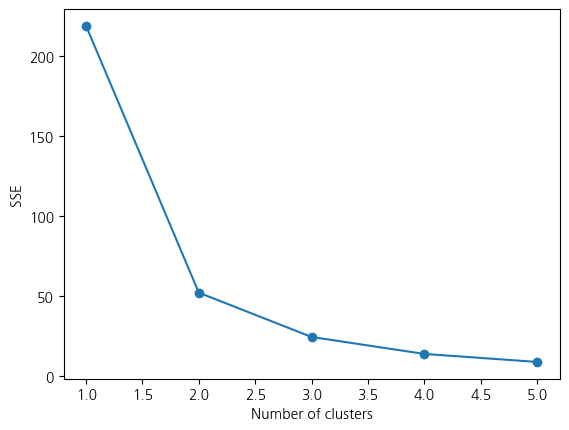

In [ ]:
checkElbow(cols_df_normalized)

In [14]:
total_df_normalized, kmeans_cols_df_normalized = kmeans_draw_3d_plot(result_df, cols_df_normalized, '구매제품수', '평균결제금액', 4)

            구매제품수    평균결제금액
cluster                    
0        0.753774  0.648735
1        0.136536  0.987044
2        0.937242  0.330059
3        0.458060  0.882886
----------------------------------------------------------------------------------------------------
cluster
1          684
3          333
0          271
2          180
dtype: int64


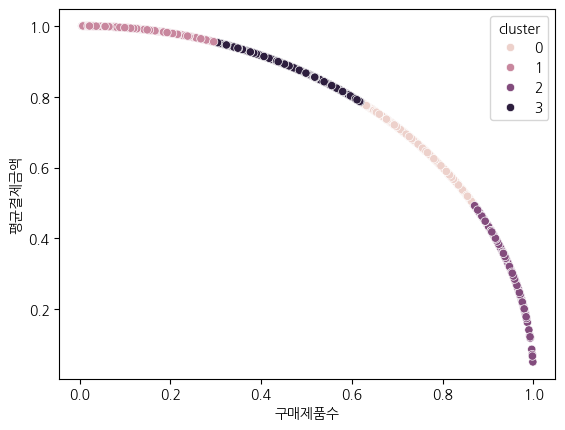

In [15]:
drawScatterplot(total_df_normalized, '구매제품수', '평균결제금액')

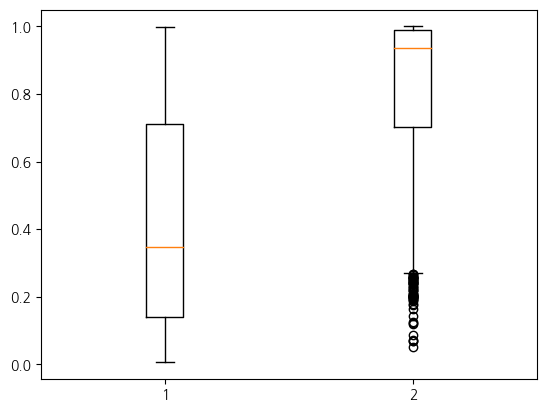

In [16]:
fig, ax = plt.subplots()

ax.boxplot([ total_df_normalized['구매제품수'], total_df_normalized['평균결제금액']]);

- --> 이상치가 존재하긴 하나 normalize 적용한 것이 가장 군집이 명확하게 구분되므로 normalized된 '구매제품수', '평균결제금액'을 기반으로 한 군집 사용

In [18]:
total_df_normalized_original = pd.concat([total_df_normalized.drop(['구매제품수', '평균결제금액'], axis=1), result_df[['구매제품수', '평균결제금액']]], axis=1)
total_df_normalized_original

,고객ID,성별,고객지역,가입기간,가입날짜,최초거래날짜,최근거래날짜,구매횟수,구매원가,할인가,배송료,총결제금액,평균할인차액,평균할인비율,구매제품평균금액,cluster,구매제품수,평균결제금액
0,USER_1358,남,Chicago,12,2019-01-01,2019-01-01,2019-01-26,177,38520.24,37377.56,1749.28,39126.84,-6.46,0.03,32.99,2,1133,221.06
1,USER_0190,남,California,43,2016-04-19,2019-01-01,2019-12-18,26,3360.52,3032.86,200.46,3233.32,-12.60,0.10,17.33,0,175,124.36
2,USER_0066,남,Chicago,33,2017-01-31,2019-01-01,2019-08-02,15,2671.90,2563.56,195.70,2759.26,-7.22,0.04,16.54,0,155,183.95
3,USER_0345,여,California,30,2017-05-23,2019-01-01,2019-01-01,1,1.46,1.46,6.50,7.96,0.00,0.00,1.46,1,1,7.96
4,USER_0683,남,California,49,2015-12-01,2019-01-01,2019-08-30,6,1150.17,903.36,64.38,967.74,-41.14,0.26,60.22,1,15,161.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_0513,여,New York,41,2016-07-05,2019-12-30,2019-12-31,5,559.89,491.44,31.50,522.94,-13.69,0.13,16.95,1,29,104.59
1464,USER_0167,여,Chicago,48,2016-01-05,2019-12-31,2019-12-31,14,3272.39,3150.20,103.99,3254.19,-8.73,0.04,90.01,1,35,232.44
1465,USER_0845,남,New Jersey,19,2018-04-17,2019-12-31,2019-12-31,3,810.39,803.39,19.50,822.89,-2.33,0.01,80.34,1,10,274.30
1466,USER_0504,여,New York,45,2016-02-02,2019-12-31,2019-12-31,6,1198.59,1131.15,39.00,1170.15,-11.24,0.06,102.83,1,11,195.02


# 2. EDA

### 가입기간, 구매횟수, 총결제금액, 평균결제금액, 구매제품수

In [20]:
normalized_0 = total_df_normalized_original[total_df_normalized_original['cluster'] == 0]
normalized_1 = total_df_normalized_original[total_df_normalized_original['cluster'] == 1]
normalized_2 = total_df_normalized_original[total_df_normalized_original['cluster'] == 2]
normalized_3 = total_df_normalized_original[total_df_normalized_original['cluster'] == 3]

In [21]:
normalized_0.describe()[['가입기간','총결제금액', '평균결제금액', '구매횟수', '구매제품수']]

,가입기간,총결제금액,평균결제금액,구매횟수,구매제품수
count,271.000000,271.000000,271.000000,271.000000,271.000000
mean,26.132841,4613.672952,187.373321,24.608856,225.586716
std,13.628567,3065.028935,82.433696,13.912762,118.537597
min,2.000000,196.150000,32.690000,3.000000,39.000000
25%,15.000000,2302.810000,140.200000,13.000000,153.000000
50%,27.000000,3775.330000,172.700000,23.000000,206.000000
75%,38.500000,6131.985000,209.445000,33.000000,266.000000
max,50.000000,17443.750000,734.730000,70.000000,1141.000000


In [22]:
normalized_1.describe()[['가입기간','총결제금액', '평균결제금액', '구매횟수', '구매제품수']]

,가입기간,총결제금액,평균결제금액,구매횟수,구매제품수
count,684.000000,684.000000,684.000000,684.000000,684.000000
mean,25.907895,1168.208582,172.062281,6.549708,23.820175
std,14.139402,1234.389058,156.843678,5.559647,27.128156
min,2.000000,6.990000,6.990000,1.000000,1.000000
25%,14.000000,292.292500,95.685000,2.000000,7.000000
50%,25.000000,840.625000,153.545000,5.000000,17.000000
75%,38.000000,1654.885000,207.335000,9.000000,32.000000
max,50.000000,8876.030000,1867.750000,38.000000,289.000000


In [23]:
normalized_2.describe()[['가입기간','총결제금액', '평균결제금액', '구매횟수', '구매제품수']]

,가입기간,총결제금액,평균결제금액,구매횟수,구매제품수
count,180.000000,180.000000,180.000000,180.000000,180.000000
mean,26.227778,11256.758722,204.966444,55.611111,716.577778
std,12.963132,11626.108617,95.396622,49.812653,611.950576
min,2.000000,1391.700000,82.380000,7.000000,200.000000
25%,16.000000,4884.810000,164.152500,28.000000,396.500000
50%,28.000000,8148.005000,185.515000,42.000000,532.000000
75%,36.250000,12450.830000,212.377500,65.000000,799.500000
max,49.000000,84405.830000,971.390000,328.000000,4869.000000


In [24]:
normalized_3.describe()[['가입기간','총결제금액', '평균결제금액', '구매횟수', '구매제품수']]

,가입기간,총결제금액,평균결제금액,구매횟수,구매제품수
count,333.000000,333.000000,333.000000,333.000000,333.000000
mean,25.570571,3015.458048,180.240631,16.432432,94.960961
std,14.419656,2433.482164,77.798250,11.070384,49.234150
min,2.000000,28.430000,27.180000,1.000000,10.000000
25%,12.000000,1249.000000,131.970000,8.000000,62.000000
50%,26.000000,2487.110000,173.780000,14.000000,88.000000
75%,38.000000,4102.620000,212.960000,22.000000,117.000000
max,50.000000,18570.500000,622.060000,78.000000,373.000000


- --> 가입기간 : 클러스터마다 별 차이 없음

- boxplot

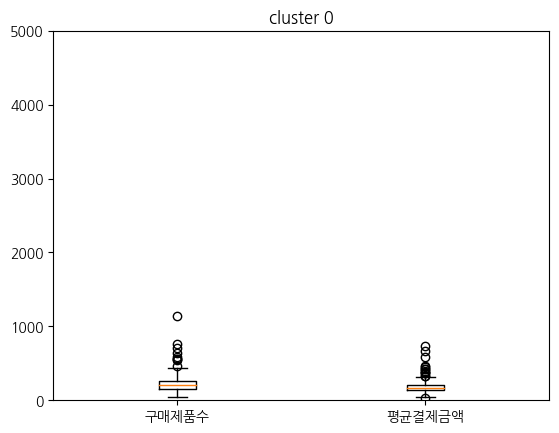

In [26]:
fig, ax = plt.subplots()

ax.boxplot([normalized_0['구매제품수'], normalized_0['평균결제금액']])
plt.ylim([0, 5000])
plt.xticks([1, 2], ['구매제품수', '평균결제금액'])
plt.title('cluster 0');

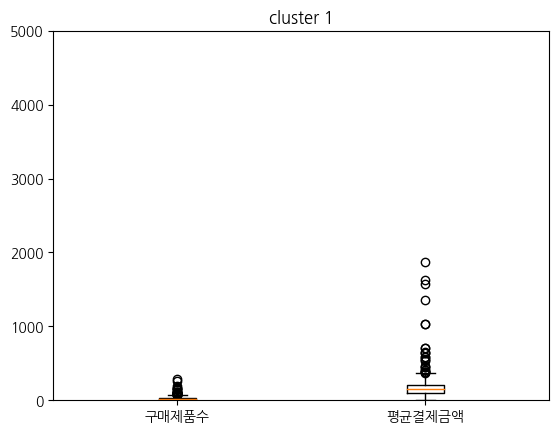

In [28]:
fig, ax = plt.subplots()

ax.boxplot([normalized_1['구매제품수'], normalized_1['평균결제금액']])
plt.ylim([0, 5000])
plt.xticks([1, 2], ['구매제품수', '평균결제금액'])
plt.title('cluster 1');

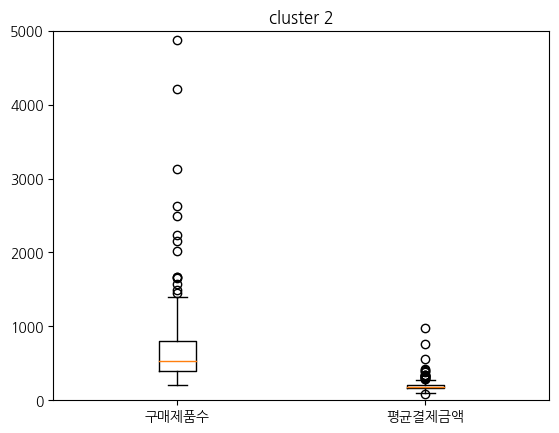

In [29]:
fig, ax = plt.subplots()

ax.boxplot([normalized_2['구매제품수'], normalized_2['평균결제금액']])
plt.ylim([0, 5000])
plt.xticks([1, 2], ['구매제품수', '평균결제금액'])
plt.title('cluster 2');

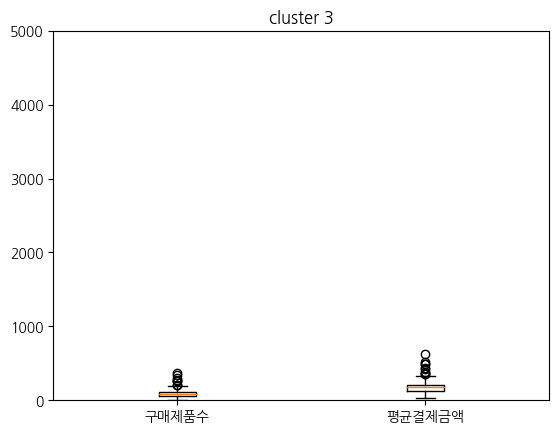

In [30]:
fig, ax = plt.subplots()

ax.boxplot([normalized_3['구매제품수'], normalized_3['평균결제금액']])
plt.ylim([0, 5000])
plt.xticks([1, 2], ['구매제품수', '평균결제금액'])
plt.title('cluster 3');

- barplot

In [31]:
# 그래프 그리기
def drawBarplot(df, col):

  plt.figure(figsize=(10, 6))
  sns.barplot(data = df, x = df[col], hue = df['cluster'])
  plt.xlabel(col)
  plt.xticks(rotation=45, ha='right')
  plt.legend()
  plt.show()

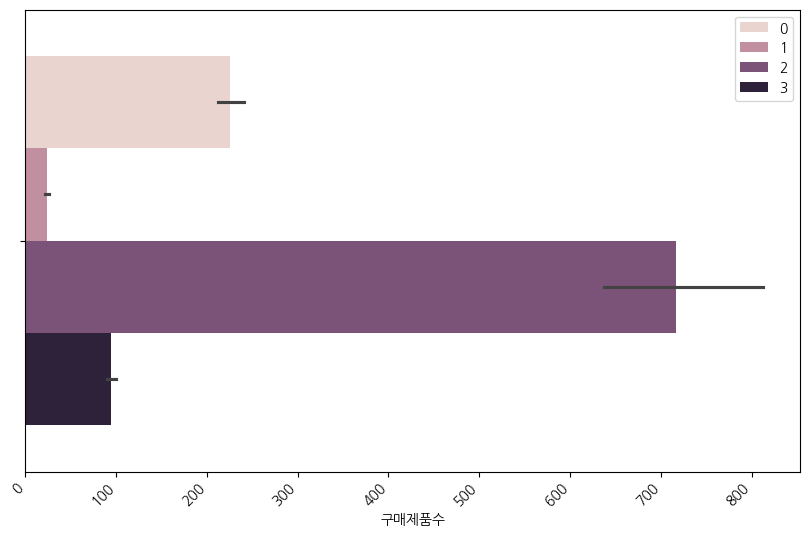

In [32]:
drawBarplot(total_df_normalized_original, '구매제품수')

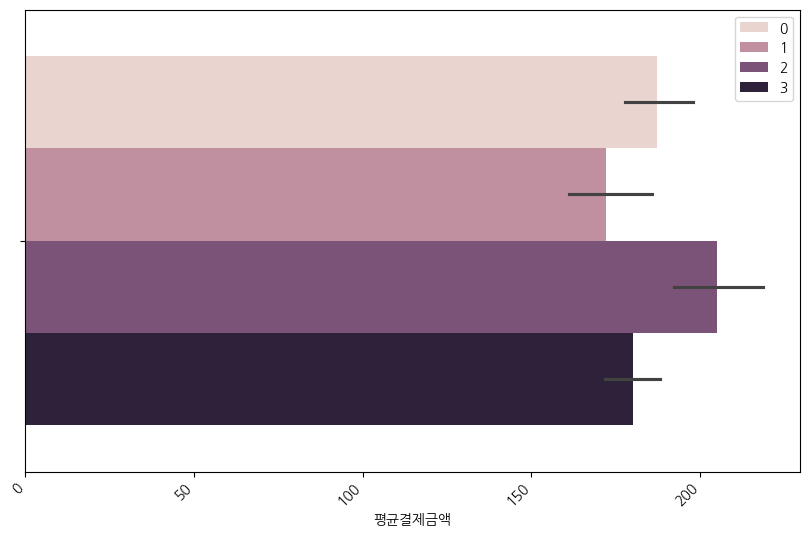

In [33]:
drawBarplot(total_df_normalized_original, '평균결제금액')

- 각 클러스터에 속한 고객 수

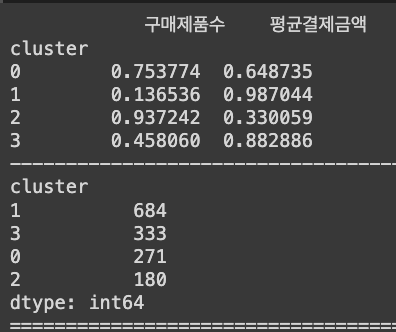

- --> 정리
  - 2 : 구매제품수 가장 많음, 평균 결제금액 가장 높음, 고객 수 가장 적음
  - 1 : 구매제품수 가장 적음, 평균 결제금액 가장 낮음, 고객 수 가장 많음

### 고객 지역

In [36]:
normalized_2['고객지역'].value_counts()

Chicago          66
California       50
New York         39
New Jersey       15
Washington DC    10
Name: 고객지역, dtype: int64

In [37]:
normalized_0['고객지역'].value_counts()

California       92
Chicago          86
New York         56
New Jersey       24
Washington DC    13
Name: 고객지역, dtype: int64

In [38]:
normalized_3['고객지역'].value_counts()

California       101
Chicago           98
New York          74
New Jersey        39
Washington DC     21
Name: 고객지역, dtype: int64

In [39]:
normalized_1['고객지역'].value_counts()

California       221
Chicago          206
New York         155
New Jersey        71
Washington DC     31
Name: 고객지역, dtype: int64

- 클러스터 별로 고객지역 차이 없음

- 제품카테고리

In [40]:
tmp_df_cluster = pd.merge(onlinesales_info, total_df_normalized_original, on='고객ID', how='left')[['고객ID', '제품ID', '제품카테고리', '수량', '평균금액', '성별', '쿠폰상태', 'cluster']]
tmp_df_cluster

,고객ID,제품ID,제품카테고리,수량,평균금액,성별,쿠폰상태,cluster
0,USER_1358,Product_0981,Nest-USA,1,153.71,남,Used,2
1,USER_1358,Product_0981,Nest-USA,1,153.71,남,Used,2
2,USER_1358,Product_0904,Office,1,2.05,남,Used,2
3,USER_1358,Product_0203,Apparel,5,17.53,남,Not Used,2
4,USER_1358,Product_0848,Bags,1,16.50,남,Used,2
...,...,...,...,...,...,...,...,...
52919,USER_0504,Product_0976,Nest-USA,1,121.30,여,Clicked,1
52920,USER_0504,Product_0413,Apparel,1,48.92,여,Used,1
52921,USER_0504,Product_0989,Nest-USA,1,151.88,여,Used,1
52922,USER_0562,Product_0985,Nest-USA,5,80.52,여,Clicked,1


In [41]:
tmp_df_cluster_category = tmp_df_cluster.groupby(['cluster', '제품카테고리'])['수량'].sum().reset_index().rename(columns={'수량':'총구매수량'})
tmp_df_cluster_category

,cluster,제품카테고리,총구매수량
0,0,Accessories,376
1,0,Android,11
2,0,Apparel,8178
3,0,Backpacks,26
4,0,Bags,4098
...,...,...,...
75,3,Nest-Canada,122
76,3,Nest-USA,4620
77,3,Notebooks & Journals,843
78,3,Office,9839


In [42]:
tmp_df_cluster_category.sort_values(by='총구매수량', ascending=False).head(10)

,cluster,제품카테고리,총구매수량
58,2,Office,53269
18,0,Office,22491
46,2,Drinkware,17378
52,2,Lifestyle,14104
42,2,Apparel,13895
78,3,Office,9839
44,2,Bags,8884
2,0,Apparel,8178
6,0,Drinkware,8007
56,2,Nest-USA,7723


- --> 클러스터 2, 0 모두 office 총구매수량이 가장 높음
  - --> 클러스터 2는 고객 수가 낮음에도 구매제품수, 평균결제금액 모두 높은 군집인데 가격도 낮은 편에 속하는 office의 총구매수량이 가장 높다는 것은 특정 고객이 한번 구매할 때 많은 양의 office를 사들일 가능성 농후

In [44]:
tmp_df_cluster[(tmp_df_cluster['제품카테고리'] == 'Nest')].groupby(['cluster'])['수량'].sum().reset_index().sort_values('수량', ascending=False)

,cluster,수량
2,2,847
0,0,692
3,3,688
1,1,610


In [ ]:
tmp_df_cluster[(tmp_df_cluster['제품카테고리'] == 'Nest-USA')].groupby(['cluster'])['수량'].sum().reset_index().sort_values('수량', ascending=False)

,cluster,수량
2,2,7661
0,0,5204
3,3,4716
1,1,3849


- --> 그렇다고 평균 가격에 높았던 카테고리의 제품을 안사는 것은 아님

In [45]:
tmp_df_cluster_category[tmp_df_cluster_category['cluster'].isin([3, 1])].sort_values(by='총구매수량', ascending=False).head(10)

,cluster,제품카테고리,총구매수량
78,3,Office,9839
62,3,Apparel,5823
76,3,Nest-USA,4620
22,1,Apparel,4542
36,1,Nest-USA,3942
66,3,Drinkware,3515
72,3,Lifestyle,3062
38,1,Office,2784
64,3,Bags,1619
26,1,Drinkware,1601


- --> 클러스터 3도 마찬가지로 office 카테고리에서 많은 구매가 일어났으나 클러스터 1에서는 apparel에서 가장 많은 구매가 일어남
  - --> Office에 비해 Apparel은 비교적 높은 가격대임

In [46]:
tmp_df_cluster_category[tmp_df_cluster_category['cluster'] == 1].sort_values(by='총구매수량', ascending=False)

,cluster,제품카테고리,총구매수량
22,1,Apparel,4542
36,1,Nest-USA,3942
38,1,Office,2784
26,1,Drinkware,1601
32,1,Lifestyle,1067
24,1,Bags,672
34,1,Nest,610
37,1,Notebooks & Journals,371
30,1,Headgear,155
39,1,Waze,134


- --> 클러스터 1 : 고객 수가 가장 많으나 구매제품수, 평균결제금액이 가장 낮은 편에 속했던 그룹
  - -> Apparel의 구매 수량이 가장 많지만 이는 다른 클러스터에 비하면 적은편이고 높은 가격대인 Nest, Nest-USA도 모두 다른 클러스터에 비해 구매수량이 낮은 편
    - --> 전반적으로 클러스터 1은 구매횟수와 평균 결제금액이 낮지만 고객 수가 가장 많은 그룹이므로 일반 고객들로 구성된 그룹으로 볼 수 있음

In [59]:
total_df_normalized_original[['고객ID', 'cluster']].to_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/cluster_yujisu.csv')